In [1]:
import av

import tensorflow as tf

import keras
from keras import layers
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam

import shutil
import imghdr
from PIL import Image

import os
import random
import numpy as np
import pickle
from matplotlib import pyplot as plt

import tempfile
import tensorflow_model_optimization as tfmot

In [2]:
DS_CDFV1 = 'celeb_df_v1/'
DS_CDFV2 = 'celeb_df_v2/'

DS_ORGINAL = 'dataset_original/'
DS_SPLIT = 'dataset_split/'
DS_IFRAMES = 'dataset_iframes/'
DS_FACE = 'dataset_face/'
DS_FACE_IMG = 'dataset_face_img/'
DS_SRM_SNIPPETS = 'dataset_srm_snippets_5/'
DS_SEGMENTS = 'dataset_segments/'
DS_RAW = 'dataset_raw/'
DS_RESIDUALS = 'dataset_residuals/'
DS_TEMPORAL = 'dataset_temporal/'


SEG_1 = 'seg_1/'
SEG_2 = 'seg_2/'
SEG_3 = 'seg_3/'
SEG_4 = 'seg_4/'
SEG_5 = 'seg_5/'

SEG = ['seg_1_', 'seg_2_', 'seg_3_', 'seg_4_', 'seg_5_']

DS_TRAIN = 'train_dataset/'
DS_TEST = 'test_dataset/'
DS_VAL = 'val_dataset/'

CLASS_FAKE = 'fake/'
CLASS_REAL = 'real/'


TOP_LEVEL_1 = [DS_SPLIT, DS_IFRAMES, DS_FACE, DS_FACE_IMG, DS_SRM_SNIPPETS]
TOP_LEVEL_2 = [DS_SEGMENTS, DS_RAW, DS_RESIDUALS]
SEGMENTS = [SEG_1, SEG_2, SEG_3, SEG_4, SEG_5]
SPLIT = [DS_TRAIN, DS_TEST, DS_VAL]
CLASS = [CLASS_REAL, CLASS_FAKE]

DATASET = [DS_CDFV1, DS_CDFV2]

In [4]:
SAVE_CHECKPOINT_PATH = 'models/Mesonet/checkpoints/'
SAVE_METRICS_PATH = 'models/Mesonet/metrics/'
SAVE_MODEL_PATH = 'models/Mesonet/final_model/'
BACKUP_MODEL_PATH = 'models/Mesonet/backups/'

TEST_SCORE_PATH = 'test_scores/'

# Frame Extraction

## Functions

In [29]:
def extract_frames_from_video(fp):
    vid_container = av.open(fp)

    frames = []
    for frame in vid_container.decode():
        frames.append(frame.to_image())

    return frames

In [30]:
def create_face_image_dataset(dataset):
    assert dataset == DS_CDFV1 or dataset == DS_CDFV2

    src_base_path = dataset + DS_FACE
    dst_base_path = dataset + DS_FACE_IMG

    for split in SPLIT:
        print(f'---Split started: {split}---')

        for class_dir in CLASS:
            print(f'Class started: {class_dir}')

            for video in os.listdir(src_base_path + split + class_dir):
                fp = src_base_path + split + class_dir + video
                frames = extract_frames_from_video(fp)

                for i, frame in enumerate(frames, start=1):
                    dst = f'{dst_base_path + split + class_dir + os.path.splitext(video)[0]}_f{i}.jpeg'
                    frame.save(dst)

## Celeb DF Dataset

In [12]:
create_face_image_dataset(DS_CDFV1)

---Split started: train_dataset/---
Class started: real/
Class started: fake/
---Split started: test_dataset/---
Class started: real/
Class started: fake/
---Split started: val_dataset/---
Class started: real/
Class started: fake/


In [15]:
create_face_image_dataset(DS_CDFV2)

---Split started: train_dataset/---
Class started: real/
Class started: fake/
---Split started: test_dataset/---
Class started: real/
Class started: fake/
---Split started: val_dataset/---
Class started: real/
Class started: fake/


# Tensor Dataset Creation

In [104]:
def create_tensor_dataset(dataset, split):
    ds = keras.utils.image_dataset_from_directory(
        directory = dataset + DS_FACE_IMG + split,
        labels = 'inferred',
        label_mode = 'binary',
        batch_size = 32,
        color_mode = 'rgb',
        shuffle = True,
        seed = 1
    )

    return ds

In [5]:
# Celeb DF v1 Dataset

train_dataset_cdfv1 = create_tensor_dataset(DS_CDFV1, DS_TRAIN)
test_dataset_cdfv1 = create_tensor_dataset(DS_CDFV1, DS_TEST)
val_dataset_cdfv1 = create_tensor_dataset(DS_CDFV1, DS_VAL)

Found 30404 files belonging to 2 classes.
Found 3299 files belonging to 2 classes.
Found 7507 files belonging to 2 classes.


In [105]:
# Celeb DF v2 Dataset

train_dataset_cdfv2 = create_tensor_dataset(DS_CDFV2, DS_TRAIN)
test_dataset_cdfv2 = create_tensor_dataset(DS_CDFV2, DS_TEST)
val_dataset_cdfv2 = create_tensor_dataset(DS_CDFV2, DS_VAL)

Found 153411 files belonging to 2 classes.
Found 16670 files belonging to 2 classes.
Found 38675 files belonging to 2 classes.


# Model Creation

In [7]:
def create_model(input_size):
    model = keras.Sequential(name='Mesonet')
    model.add(layers.Conv2D(input_shape=input_size, filters=8, kernel_size=3, activation='relu', padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2, 2, padding="same"))

    model.add(layers.Conv2D(input_shape=(128, 128, 8), filters=8, kernel_size=5, activation='relu', padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2, 2, padding="same"))

  
    model.add(layers.Conv2D(input_shape=(64, 64, 8), filters=16, kernel_size=5, activation='relu', padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(4, 4, padding="same"))

  
    model.add(layers.Conv2D(input_shape=(16, 16, 16), filters=16, kernel_size=5, activation='relu', padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(4, 4, padding="same"))
    model.add(Flatten())

    model.add(Dropout(0.5))
    model.add(layers.Dense(16))
    model.add(layers.LeakyReLU())

    model.add(Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
  
    return model

In [8]:
input_size = (256, 256, 3)
mesonet_model = create_model(input_size)
mesonet_model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss=keras.losses.BinaryCrossentropy(), 
              metrics = [keras.metrics.BinaryAccuracy(), 
                         keras.metrics.Precision(), 
                         keras.metrics.Recall(),
                         keras.metrics.AUC(),
                         keras.metrics.FalseNegatives(),
                         keras.metrics.FalsePositives(),
                         keras.metrics.TrueNegatives(),
                         keras.metrics.TruePositives()])
mesonet_model.summary()

Model: "Mesonet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 8)      32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 8)       1608      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 8)      32        
 hNormalization)                                                 
                                                           

## Model Callbacks

In [6]:
class MetricsCheckPoint(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):

        metrics_dict = {}
        if os.path.exists(SAVE_METRICS_PATH + 'metrics.pkl'):
            with open(SAVE_METRICS_PATH + 'metrics.pkl', 'rb') as f:
                metrics_dict = pickle.load(f)

        for key, value in logs.items():
            if key not in metrics_dict:
                metrics_dict[key] = []

            metrics_dict[key].append(value)

        with open(SAVE_METRICS_PATH + 'metrics.pkl', 'wb') as f:
            pickle.dump(metrics_dict, f)

In [7]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = SAVE_CHECKPOINT_PATH + 'checkpoint',
    save_weights_only = True
)

In [8]:
early_stopping_callback = keras.callbacks.EarlyStopping(
    patience = 10,
    restore_best_weights = True,
    start_from_epoch = 100
)

In [9]:
model_restore_callback = keras.callbacks.BackupAndRestore(
    backup_dir = BACKUP_MODEL_PATH + 'backup'
)

# Model Training

In [16]:
def train_model(model, train_ds, val_ds, max_epochs):
    history = model.fit(train_ds,
                        epochs = max_epochs,
                        validation_data = val_ds,
                        callbacks = [MetricsCheckPoint(), 
                                     model_checkpoint_callback,
                                     early_stopping_callback,
                                     model_restore_callback])
    
    return history, model

In [17]:
history, mesonet_model = train_model(mesonet_model, train_dataset_cdfv1, val_dataset_cdfv1, 2)

Epoch 1/2
951/951 [==============================] - 1342s 1s/step - loss: 1.1755 - binary_accuracy: 0.5934 - precision: 0.4293 - recall: 0.4240 - auc: 0.5715 - false_negatives: 6249.0000 - false_positives: 6114.0000 - val_loss: 0.5721 - val_binary_accuracy: 0.7271 - val_precision: 0.8319 - val_recall: 0.2257 - val_auc: 0.7223 - val_false_negatives: 1935.0000 - val_false_positives: 114.0000
Epoch 2/2
951/951 [==============================] - 1166s 1s/step - loss: 0.7595 - binary_accuracy: 0.6710 - precision: 0.5441 - recall: 0.4816 - auc: 0.6780 - false_negatives: 5624.0000 - false_positives: 4378.0000 - val_loss: 0.5390 - val_binary_accuracy: 0.7458 - val_precision: 0.8644 - val_recall: 0.2805 - val_auc: 0.7649 - val_false_negatives: 1798.0000 - val_false_positives: 110.0000


## Saving and Loading model

In [ ]:
# Saves last epoch's weights if early stopping was not used
# Saves previous best epoch's weights if early stopping occurred
mesonet_model.save_weights(SAVE_MODEL_PATH + 'model')

In [ ]:
mesonet_model.load_weights(SAVE_MODEL_PATH + 'model')

In [9]:
mesonet_model.load_weights(SAVE_CHECKPOINT_PATH + 'checkpoint')

## Pre-Pruning Metrics

### Train Metrics

In [13]:
metrics = {}
with open(SAVE_METRICS_PATH + 'metrics.pkl', 'rb') as f:
    metrics = pickle.load(f)

acc = metrics['binary_accuracy']
val_acc = metrics['val_binary_accuracy']

precision = metrics['precision']
val_precision = metrics['val_precision']

recall = metrics['recall']
val_recall = metrics['val_recall']

auc = metrics['auc']
val_auc = metrics['val_auc']

loss = metrics['loss']
val_loss = metrics['val_loss']

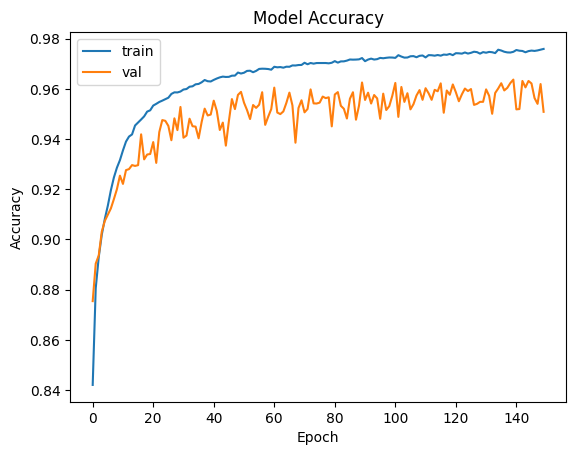

In [19]:
plt.plot(acc)
plt.plot(val_acc)

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

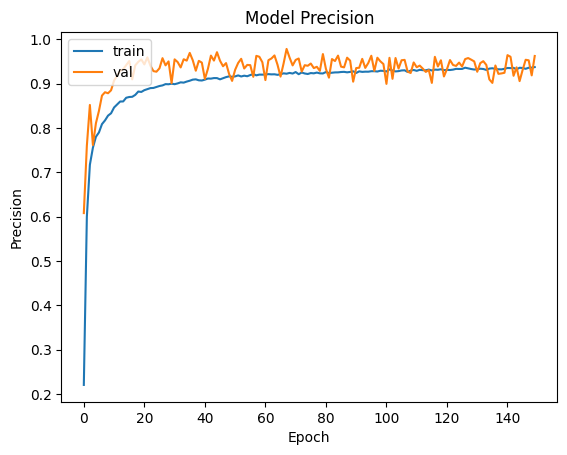

In [20]:
plt.plot(precision)
plt.plot(val_precision)

plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

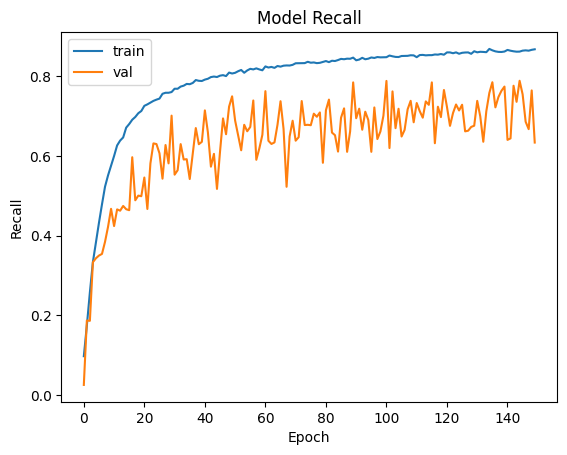

In [21]:
plt.plot(recall)
plt.plot(val_recall)

plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

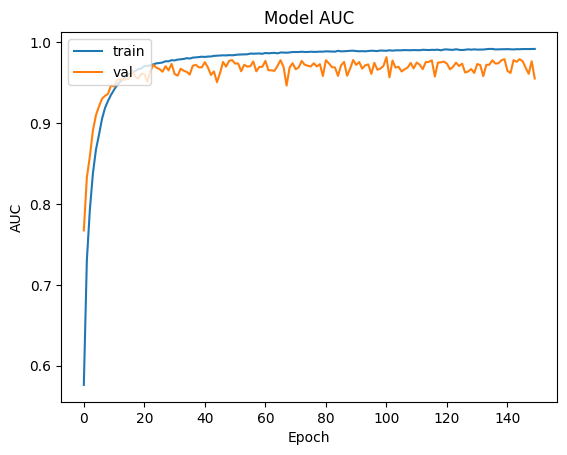

In [22]:
plt.plot(auc)
plt.plot(val_auc)

plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

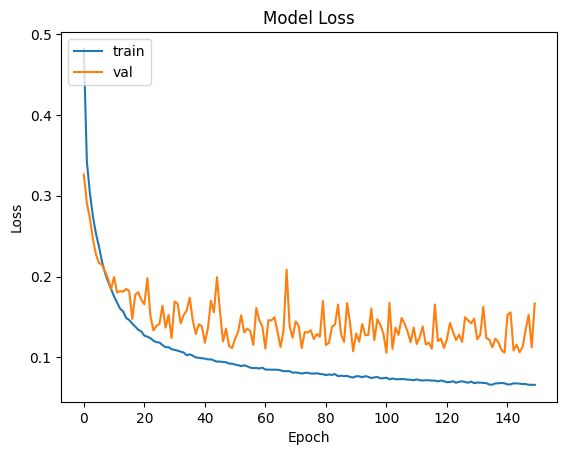

In [23]:
plt.plot(loss)
plt.plot(val_loss)

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Test Metrics (Frame Level)

In [106]:
loss, acc, prec, rec, auc, fn, fp, tn, tp = mesonet_model.evaluate(test_dataset_cdfv2)

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f'Precision: {prec:.4f}')
print(f'Recall: {rec:.4f}')
print(f'AUC: {auc:.4f}')
print('--------------------')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')
print(f'True Positives: {tp}')
print(f'True Negatives: {tn}')

521/521 [==============================] - 1447s 3s/step - loss: 0.3278 - binary_accuracy: 0.9023 - precision: 0.9651 - recall: 0.7507 - auc: 0.9595 - false_negatives: 1469.0000 - false_positives: 160.0000 - true_negatives: 10618.0000 - true_positives: 4423.0000
Loss: 0.3278
Accuracy: 0.9023
Precision: 0.9651
Recall: 0.7507
AUC: 0.9595
--------------------
False Positives: 160.0
False Negatives: 1469.0
True Positives: 4423.0
True Negatives: 10618.0


# Model Pruning

## Pruning Dense Layers

In [10]:
# Pruning only dense layers
# Helper function uses `prune_low_magnitude` to make only the 
# Dense layers train with pruning.
def apply_pruning_to_dense(layer):
    
    if isinstance(layer, keras.layers.Dense):
        return tfmot.sparsity.keras.prune_low_magnitude(layer)
    
    return layer

In [11]:
# Use `tf.keras.models.clone_model` to apply `apply_pruning_to_dense` 
# to the layers of the model.
mesonet_model_dense_prune = keras.models.clone_model(
    mesonet_model,
    clone_function=apply_pruning_to_dense,
)

mesonet_model_dense_prune.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=Adam(learning_rate=0.0001),
    metrics = [keras.metrics.BinaryAccuracy(), 
                         keras.metrics.Precision(), 
                         keras.metrics.Recall(),
                         keras.metrics.AUC(),
                         keras.metrics.FalseNegatives(),
                         keras.metrics.FalsePositives(),
                         keras.metrics.TrueNegatives(),
                         keras.metrics.TruePositives()]
)

mesonet_model_dense_prune.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "Mesonet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 8)      32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 8)       1608      
                                                        

## Pruning All Layers

In [13]:
end_step = np.ceil(30585/32).astype(np.int32) * 20

In [14]:
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

mesonet_model_all_prune = tfmot.sparsity.keras.prune_low_magnitude(mesonet_model, **pruning_params)
mesonet_model_all_prune.summary()

Model: "Mesonet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d   (None, 256, 256, 8)      442       
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_batch_n  (None, 256, 256, 8)      33        
 ormalization (PruneLowMagni                                     
 tude)                                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 128, 128, 8)      1         
 ling2d (PruneLowMagnitude)                                      
                                                                 
 prune_low_magnitude_conv2d_  (None, 128, 128, 8)      3210      
 1 (PruneLowMagnitude)                                           
                                                           

## Pruning

In [12]:
mesonet_model_dense_prune.load_weights(SAVE_MODEL_PATH + 'model_pruned')

In [4]:
metrics = {}
with open(SAVE_METRICS_PATH + 'metrics_pruned.pkl', 'rb') as f:
    metrics = pickle.load(f)

acc = metrics['binary_accuracy']
val_acc = metrics['val_binary_accuracy']

precision = metrics['precision']
val_precision = metrics['val_precision']

recall = metrics['recall']
val_recall = metrics['val_recall']

auc = metrics['auc']
val_auc = metrics['val_auc']

loss = metrics['loss']
val_loss = metrics['val_loss']

precision_2 = metrics['precision_2']
val_precision_2 = metrics['val_precision_2']
precision.extend(precision_2)
val_precision.extend(val_precision_2)

recall_2 = metrics['recall_2']
val_recall_2 = metrics['val_recall_2']
recall.extend(recall_2)
val_recall.extend(val_recall_2)

auc_2 = metrics['auc_2']
val_auc_2 = metrics['val_auc_2']
auc.extend(auc_2)
val_auc.extend(val_auc_2)

In [49]:
print(metrics.keys())

dict_keys(['loss', 'binary_accuracy', 'precision', 'recall', 'auc', 'false_negatives', 'false_positives', 'true_negatives', 'true_positives', 'val_loss', 'val_binary_accuracy', 'val_precision', 'val_recall', 'val_auc', 'val_false_negatives', 'val_false_positives', 'val_true_negatives', 'val_true_positives', 'precision_2', 'recall_2', 'auc_2', 'false_negatives_2', 'false_positives_2', 'true_negatives_2', 'true_positives_2', 'val_precision_2', 'val_recall_2', 'val_auc_2', 'val_false_negatives_2', 'val_false_positives_2', 'val_true_negatives_2', 'val_true_positives_2'])


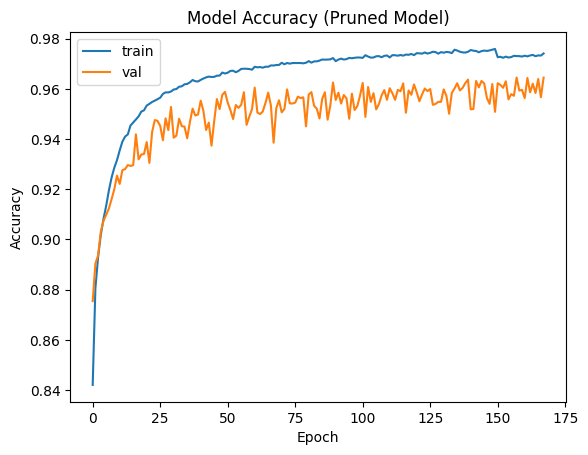

In [5]:
plt.plot(acc)
plt.plot(val_acc)

plt.title('Model Accuracy (Pruned Model)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

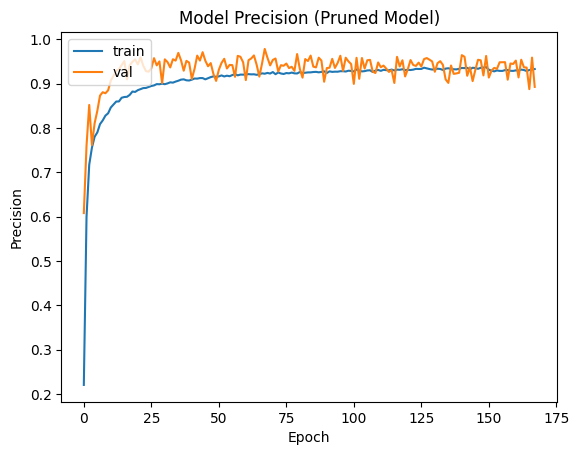

In [6]:
plt.plot(precision)
plt.plot(val_precision)

plt.title('Model Precision (Pruned Model)')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

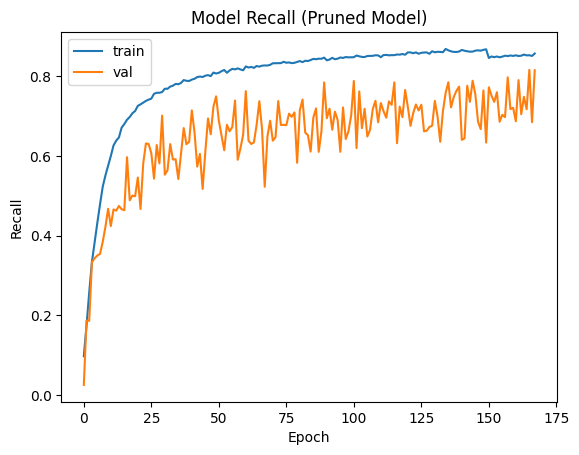

In [7]:
plt.plot(recall)
plt.plot(val_recall)

plt.title('Model Recall (Pruned Model)')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

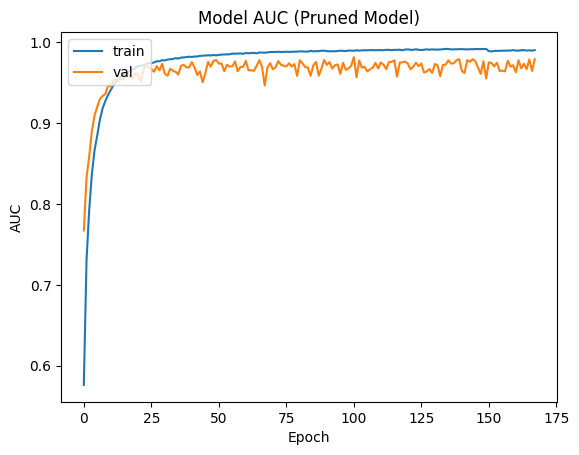

In [8]:
plt.plot(auc)
plt.plot(val_auc)

plt.title('Model AUC (Pruned Model)')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

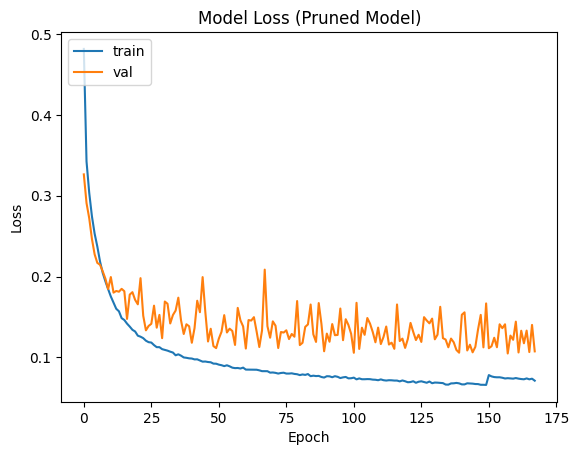

In [9]:
plt.plot(loss)
plt.plot(val_loss)

plt.title('Model Loss (Pruned Model)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Testing Metrics (Frame Level)

In [35]:
loss, acc, prec, rec, auc, fn, fp, tn, tp = mesonet_model_dense_prune.evaluate(test_dataset_cdfv2)

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f'Precision: {prec:.4f}')
print(f'Recall: {rec:.4f}')
print(f'AUC: {auc:.4f}')
print('--------------------')
print(f'False Real: {fp}')
print(f'False Fake: {fn}')
print(f'True Real: {tp}')
print(f'True Fake: {tn}')

521/521 [==============================] - 191s 352ms/step - loss: 0.3278 - binary_accuracy: 0.9023 - precision_1: 0.9651 - recall_1: 0.7507 - auc_1: 0.9595 - false_negatives_1: 1469.0000 - false_positives_1: 160.0000 - true_negatives_1: 10618.0000 - true_positives_1: 4423.0000
Loss: 0.3278
Accuracy: 0.9023
Precision: 0.9651
Recall: 0.7507
AUC: 0.9595
--------------------
False Real: 160.0
False Fake: 1469.0
True Real: 4423.0
True Fake: 10618.0


# Testing Metrics (Video Level)

In [6]:
from sklearn import metrics
import pickle

In [8]:
class VideoScore():
    def __init__(self, filename, score, true_class, fake_on_lower_half = True):
        self.filename = filename
        self.score = score
        self.true_class = true_class
        self.fake_on_lower_half = fake_on_lower_half

    def get_filename(self):
        return self.filename
    
    def get_score(self):
        return self.score
    
    def get_true_class(self):
        return self.true_class
    
    def get_fake_on_lower_half(self):
        return self.fake_on_lower_half

In [3]:
def calculate_video_score(model, fp):
    frames = extract_frames_from_video(fp)

    tf_frames = []
    for frame in frames:
        tf_frames.append(tf.convert_to_tensor(frame))

    tf_frames = tf.convert_to_tensor(tf_frames)
    results = model.predict(tf_frames, verbose=0)

    return np.average(results)

In [4]:
def calculate_scores(dataset, split, model):
    video_scores = []

    video_count = 0
    for class_dir in CLASS:
        print(f'Class Started:{class_dir}')
    
        vid_dir = dataset + DS_FACE + split + class_dir
        for video in os.listdir(vid_dir):
            fp = vid_dir + video

            video_score = VideoScore(video, 
                                    calculate_video_score(model, fp),
                                    class_dir)
            
            video_scores.append(video_score)

            video_count += 1
            if video_count % 10 == 0:
                print(f'Videos processed: {video_count}')

    return video_scores

In [23]:
def calculate_metrics(scores):
    true_fake, true_real, false_fake, false_real = 0, 0, 0, 0

    for vid_score in scores:
        score = vid_score.get_score()
        if score < 0.5 and vid_score.get_true_class() == CLASS_FAKE:
            true_fake += 1

        elif score >= 0.5 and vid_score.get_true_class() == CLASS_REAL:
            true_real += 1

        elif score < 0.5 and vid_score.get_true_class() == CLASS_REAL:
            false_fake += 1

        else:
            false_real += 1

    accuracy = (true_real + true_fake) / (true_fake + true_real + false_fake + false_real)
    precision = true_fake / (true_fake + false_fake)
    recall = true_fake / (true_fake + false_real + 3)


    y_true = [0 if x.get_true_class() == CLASS_FAKE else 1 for x in scores]
    y_score = [0 if x.get_score() < 0.5 else 1 for x in scores]

    auc = metrics.roc_auc_score(y_true, y_score)

    f1_score = (2 * precision * recall) / (precision + recall)

    all_metrics = {}
    all_metrics['true_fake'] = true_fake    
    all_metrics['true_real'] = true_real
    all_metrics['false_fake'] = false_fake
    all_metrics['false_real'] = false_real
    all_metrics['accuracy'] = accuracy
    all_metrics['precision'] = precision
    all_metrics['recall'] = recall
    all_metrics['f1_score'] = f1_score
    all_metrics['AUC'] = auc

    return all_metrics

In [ ]:
mesonet_test_scores = calculate_scores(DS_CDFV2, DS_TEST, mesonet_model)
mesonet_train_scores = calculate_scores(DS_CDFV2, DS_TRAIN, mesonet_model)

In [ ]:
mesonet_pruned_test_scores = calculate_scores(DS_CDFV2, DS_TEST, mesonet_model_dense_prune)

with open(TEST_SCORE_PATH + 'mesonet_pruned_test.pkl', 'wb') as f:
    pickle.dump(mesonet_pruned_test_scores, f)

In [ ]:
mesonet_pruned_train_scores = calculate_scores(DS_CDFV2, DS_TRAIN, mesonet_model_dense_prune)

with open(TEST_SCORE_PATH + 'mesonet_pruned_train.pkl', 'wb') as f:
    pickle.dump(mesonet_pruned_train_scores, f)

## Normal Model Metrics

In [10]:
with open(TEST_SCORE_PATH + 'mesonet_scores_test', 'rb') as f:
    mesonet_test_scores = pickle.load(f)

In [24]:
all_metrics = calculate_metrics(mesonet_test_scores)

In [30]:
print(f'Accuracy: {all_metrics["accuracy"]:.4f}')
print(f'Precision: {all_metrics["precision"]:.4f}')
print(f'Recall: {all_metrics["recall"]:.4f}')
print(f'F1 Score: {all_metrics["f1_score"]:.4f}')
print(f'AUC Score: {all_metrics["AUC"]:.4f}')

Accuracy: 0.9208
Precision: 0.8924
Recall: 0.9913
F1 Score: 0.9392
AUC Score: 0.8848


## Pruned Model Metrics

In [26]:
with open(TEST_SCORE_PATH + 'mesonet_pruned_test.pkl', 'rb') as f:
    mesonet_pruned_test_scores = pickle.load(f)

In [27]:
all_metrics = calculate_metrics(mesonet_pruned_test_scores)

In [31]:
print(f'Accuracy: {all_metrics["accuracy"]:.4f}')
print(f'Precision: {all_metrics["precision"]:.4f}')
print(f'Recall: {all_metrics["recall"]:.4f}')
print(f'F1 Score: {all_metrics["f1_score"]:.4f}')
print(f'AUC Score: {all_metrics["AUC"]:.4f}')

Accuracy: 0.9208
Precision: 0.8924
Recall: 0.9913
F1 Score: 0.9392
AUC Score: 0.8848
